#### Init Profiler

In [5]:
import numpy as np
import os
import matplotlib.pyplot as plt
from copy import deepcopy
from neuron import h
from bmtool.singlecell import Profiler, Passive, CurrentClamp, FI, ZAP

# path to template and mechs
template_dir = os.path.join('..', 'Model-Parameters' , 'components', 'templates')
mechanism_dir = os.path.join('..', 'Model-Parameters' , 'components', 'mechanisms')

# if not compiled then compile them
if(os.path.exists(mechanism_dir +'/x86_64')==False):
    current_dir = os.getcwd()
    os.chdir(mechanism_dir)
    os.system('nrnivmodl modfiles')
    os.chdir(current_dir)

profiler = Profiler(template_dir=template_dir, mechanism_dir=mechanism_dir, dt = 0.05)


def run_and_plot(sim, title, xlabel, ylabel, plot=True, plot_injection_only=False):
    X, Y = sim.execute()
    X = np.array(X)
    Y = np.array(Y)
    if plot:
        plt.figure()
        if plot_injection_only:
            t_idx = (X >= sim.inj_delay) & (X <= sim.inj_delay + sim.inj_dur)
            plt.plot(X[t_idx], Y[t_idx])
        else:
            plt.plot(X, Y)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
    return X, Y

Mechanisms already loaded from path: ../Model-Parameters/components/mechanisms.  Aborting.


#### Profiler Settings

In [6]:
noise = False
post_init_function = 'insert_mechs(0)' if noise else None

# Cell_A settings
basic_settings = {
    'Passive': {
        'celsius': 26.,
        'kwargs': {
            'inj_amp': -50.,
            'inj_delay': 1500.,
            'inj_dur': 1000.,
            'tstop': 2500.,
            'method': 'exp'
        }
    },
    'CurrentClamp': {
        'celsius': 34.,
        'kwargs': {
            'post_init_function': post_init_function,
            'inj_amp': 350.,
            'inj_delay': 1500.,
            'inj_dur': 1000.,
            'tstop': 3000.,
            'threshold': -15. #same as what we do in BMTK; could be changed to 0?
        }
    },
    'ZAP': {
        'celsius': 34.,
        'kwargs': {
            'post_init_function': post_init_function,
            'inj_amp': 100.,
            'inj_delay': 1000.,
            'inj_dur': 15000.,
            'tstop': 15500.,
            'fstart': 0.,
            'fend': 15.,
            'chirp_type': 'linear'
        }
    },
    'FI': {
        'celsius': 34.,
        'kwargs': {
            'post_init_function': post_init_function,
            'i_start': 0.,
            'i_stop': 1000.,
            'i_increment': 20.,
            'tstart': 1500.
        }
    }
}
Cell_settings = {cell: deepcopy(basic_settings) for cell in ['Cell_Af', 'Cell_Cf', 'InterneuronCellf', 'LTS_Cell']}

# FSI cell settings
settings = Cell_settings['InterneuronCellf']
settings['Passive']['celsius'] = 30.
settings['Passive']['kwargs'] = {'inj_amp': -100., 'inj_delay': 500., 'inj_dur': 500., 'tstop': 1100., 'method': 'exp2'}
settings['CurrentClamp']['celsius'] = 21.
settings['CurrentClamp']['kwargs'] = {'inj_amp': 200., 'inj_delay': 500., 'inj_dur': 500., 'tstop': 1100., 'threshold': 0.}
settings['ZAP']['celsius'] = 30.
settings['ZAP']['kwargs']['inj_amp'] = 10.
settings['FI']['celsius'] = 30.
settings['FI']['kwargs']['tstart'] = 500.

# LTS cell settings
settings = Cell_settings['LTS_Cell'] = deepcopy(Cell_settings['InterneuronCellf'])
settings['CurrentClamp']['kwargs']['inj_amp'] = 50. 

Cell_settings['Cell_Af']['ZAP'] = None

In [7]:
Cell = 'LTS_Cell' # Cell_Af Cell_Cf InterneuronCellf LTS_Cell
settings = Cell_settings[Cell]

# Ranges for each Type of Cell

| Cell | Apical Len(um)  | V_rest(mV) | R_in(Mohms)  | Tau_m(ms)   | FI Curve Threshold(pA) | FI Curve Slope(Hz/nA) |
|:-----|:----------------|:---------|:-------------|:------------|:-----------------------|:-------------------------|
| Cell_A   |  |  | |  |  | |
| Cell_C  |            |   |   |            | |   |
| PV  |               |        |     |      |              |    | 
| LTS  |            |   |   |            | |   |


#### Passive Properties

In [8]:
proc = settings['Passive']
if proc is not None:
    h.celsius = proc['celsius']
    sim = Passive(Cell, **proc['kwargs'])
    title = 'Passive Cell Current Injection'
    xlabel = 'Time (ms)'
    ylabel = 'Membrane Potential (mV)'

Injection location: LTS_Cell[0].soma[0](0.5)
Recording: LTS_Cell[0].soma[0](0.5)._ref_v


Running simulation for passive properties...

V Rest: -70.00 (mV)
Resistance: 289.81 (MOhms)
Membrane time constant: 19.43 (ms)

V_rest Calculation: Voltage taken at time 500.0 (ms) is
-70.00 (mV)

R_in Calculation: dV/dI = (v_final-v_rest)/(i_final-i_start)
(-98.98 - (-70.00)) / (-0.1 - 0)
28.98 (mV) / 0.1 (nA) = 289.81 (MOhms)

Tau Calculation: Fit a double exponential curve to the membrane potential response
f(t) = a0 + a1*exp(-t/tau1) + a2*exp(-t/tau2)
Constrained by initial value: f(0) = a0 + a1 + a2 = v_rest
Fit parameters: (a0, a1, a2, tau1, tau2) = (-98.98, 1.03, 27.95, 0.12, 19.43)
Membrane time constant is determined from the slowest exponential term: 19.43 (ms)

Sag potential: v_sag = v_peak - v_final = 0.00 (mV)
Normalized sag potential: v_sag / (v_peak - v_rest) = -0.000



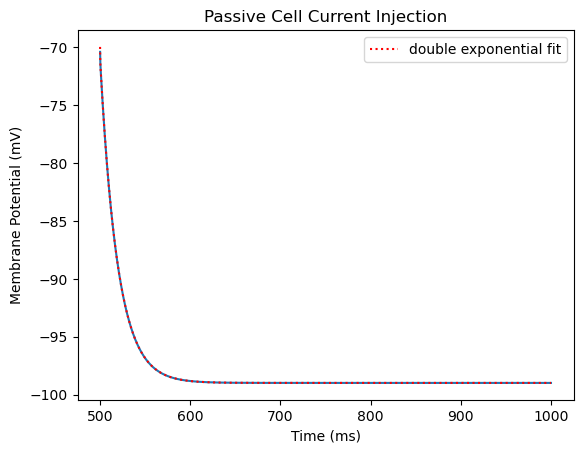

In [9]:
if sim.method =='exp2':
    X, Y = run_and_plot(sim, title, xlabel, ylabel, plot_injection_only=True)
    plt.gca().plot(*sim.double_exponential_fit(), 'r:', label='double exponential fit')
    plt.legend()
elif sim.method =='exp':
    X, Y = run_and_plot(sim, title, xlabel, ylabel, plot_injection_only=True)
    plt.gca().plot(*sim.single_exponential_fit(), 'r:', label='single exponential fit')
    plt.legend()
else:
    X, Y = run_and_plot(sim, title, xlabel, ylabel, plot_injection_only=True)
plt.show()

#### Current Injection

In [10]:
proc = settings['CurrentClamp']
if proc is not None:
    h.celsius = proc['celsius']
    sim2 = CurrentClamp(Cell, **proc['kwargs'])
    title = 'Current Injection'
    xlabel = 'Time (ms)'
    ylabel = 'Membrane Potential (mV)'

Injection location: LTS_Cell[1].soma[0](0.5)
Recording: LTS_Cell[1].soma[0](0.5)._ref_v


Current clamp simulation running...

Number of spikes: 14



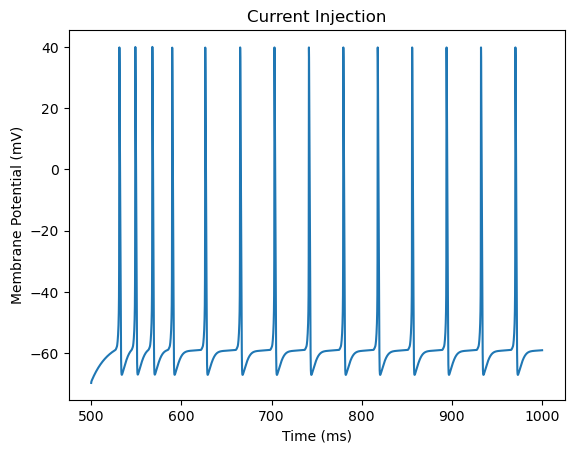

In [11]:
if proc is not None:
    X, Y = run_and_plot(sim2, title, xlabel, ylabel, plot_injection_only=True)
    plt.show()

#### Impedance Amplitude Profile (ZAP)

In [12]:
proc = settings['ZAP']
if proc is not None:
    h.celsius = proc['celsius']
    sim3 = ZAP(Cell, **proc['kwargs'])
    title = 'ZAP Response'
    xlabel = 'Time (ms)'
    ylabel = 'Membrane Potential (mV)'

Injection location: LTS_Cell[2].soma[0](0.5)
Recording: LTS_Cell[2].soma[0](0.5)._ref_v


ZAP current simulation running...

Chirp current injection with frequency changing from 0 to 15 Hz over 15 seconds
Impedance is calculated as the ratio of FFT amplitude of membrane voltage to FFT amplitude of chirp current

Resonant Peak Frequency: 0.8 (Hz)


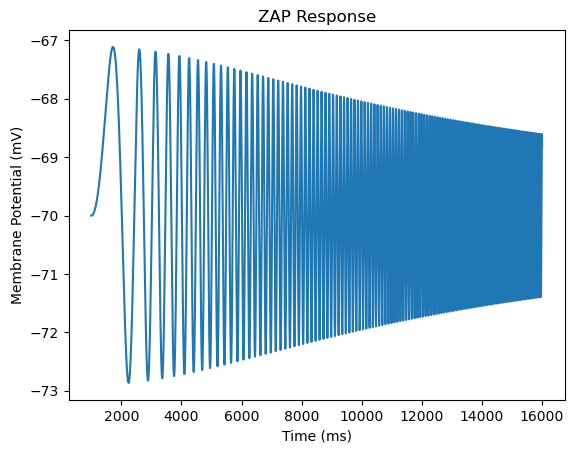

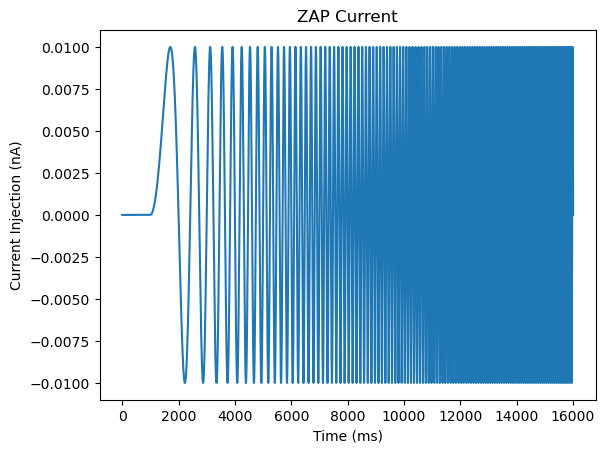

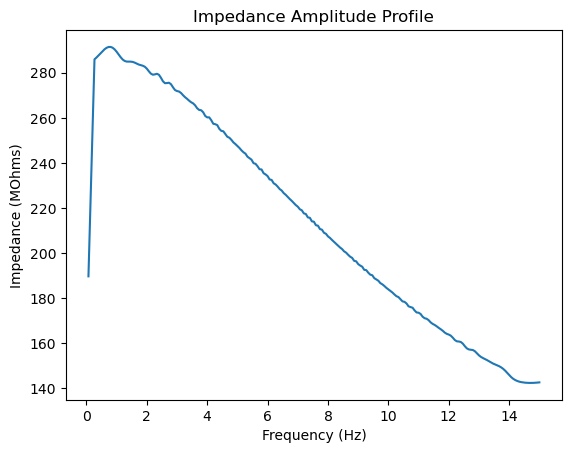

In [13]:
if proc is not None:
    X, Y = run_and_plot(sim3, title, xlabel, ylabel, plot_injection_only=True)

    plt.figure()
    plt.plot(X, sim3.zap_vec)
    plt.title('ZAP Current')
    plt.xlabel('Time (ms)')
    plt.ylabel('Current Injection (nA)')

    plt.figure()
    plt.plot(*sim3.get_impedance(smooth=9))
    plt.title('Impedance Amplitude Profile')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Impedance (MOhms)')
    plt.show()

#### F-I Curve

In [14]:
proc = settings['FI']
if proc is not None:
    h.celsius = proc['celsius']
    sim4 = FI(Cell, **proc['kwargs'])
    title = 'FI Curve'
    xlabel = 'Injection (nA)'
    ylabel = '# Spikes'

Injection location: LTS_Cell[52].soma[0](0.5)
Recording: LTS_Cell[52].soma[0](0.5)._ref_v


Running simulations for FI curve...

Results
    Injection (nA):  number of spikes
0              0.00                 0
1              0.02                 0
2              0.04                11
3              0.06                41
4              0.08                58
5              0.10                68
6              0.12                74
7              0.14                79
8              0.16                84
9              0.18                88
10             0.20                91
11             0.22                95
12             0.24                98
13             0.26               101
14             0.28               104
15             0.30               106
16             0.32               109
17             0.34               111
18             0.36               114
19             0.38               116
20             0.40               119
21             0.42               121
22             0.44               123
23             0.46               125
24   

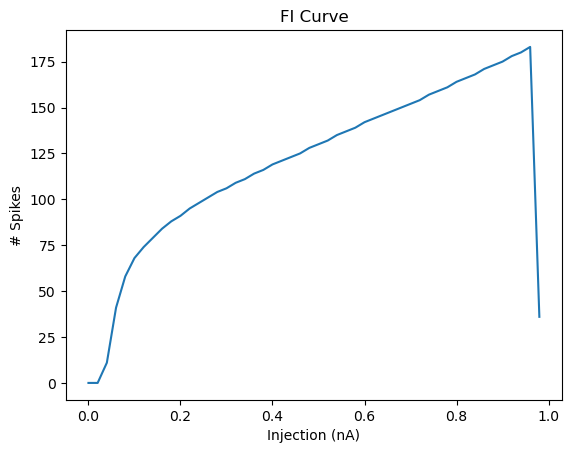

In [15]:
if proc is not None:
    X, Y = run_and_plot(sim4, title, xlabel, ylabel)
    plt.show()

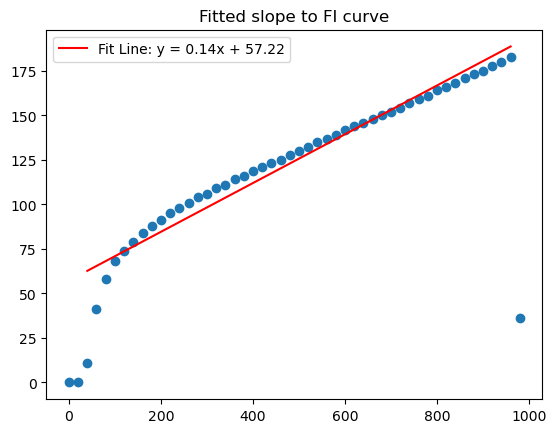

Rheobase: 40.0pA


In [16]:
def find_slope(X, Y):
    """Finds the slope and intercept using least squares
    
    """
    # Create the A matrix with a column of X and a column of ones (for the intercept term)
    A = np.vstack([X, np.ones_like(X)]).T

    # Perform least-squares fitting to find the slope (m) and intercept (c)
    m, c = np.linalg.lstsq(A, Y, rcond=None)[0]

    # Return the slope (m) and intercept (c)
    return m, c

def fit_slope_to_max_y(X, Y):
    """Fits a line between Y > 0 and the point where Y reaches its maximum"""
    # Find where Y > 0
    positive_data = Y > 0
    X_positive = X[positive_data]
    Y_positive = Y[positive_data]

    # Find the index of the maximum Y value
    max_idx = np.argmax(Y_positive)

    # Only use data from where Y is increasing up to the max value
    X_fit = X_positive[:max_idx + 1]
    Y_fit = Y_positive[:max_idx + 1]

    # Find the slope and intercept for this range
    m, c = find_slope(X_fit, Y_fit)

    return m, c, X_fit, Y_fit

def find_rheobase(X,Y):
    """Rheobase is min current to cause a spike"""
    non_zero_indices = np.nonzero(Y)[0]
    rheobase = X[non_zero_indices[0]]
    print("Rheobase: " + str(rheobase) + 'pA')

X = X * 1000 #nA to pA
m, c, X_fit, Y_fit = fit_slope_to_max_y(X, Y)
plt.scatter(X,Y)
plt.plot(X_fit, m*X_fit + c, label=f'Fit Line: y = {m:.2f}x + {c:.2f}', color='red')
plt.title("Fitted slope to FI curve")
plt.legend()
plt.show()

find_rheobase(X,Y)

In [17]:
# %matplotlib ipympl
# import numpy as np
# import matplotlib.pyplot as plt
# from neuron import h

# h.load_file("stdrun.hoc")
# h.load_file('templates/templates.hoc')

# def plot_morphology(cell):
#     fig = plt.figure()
#     ax = fig.add_subplot(111, projection='3d')

#     for sec in cell.all:
#         x = [h.x3d(i, sec=sec) for i in range(int(h.n3d(sec=sec)))]
#         y = [h.y3d(i, sec=sec) for i in range(int(h.n3d(sec=sec)))]
#         z = [h.z3d(i, sec=sec) for i in range(int(h.n3d(sec=sec)))]
#         ax.plot(x, y, z, color='k')

#     ax.set_xlabel('X')
#     ax.set_ylabel('Y')
#     ax.set_zlabel('Z')
#     plt.show()

# cell = h.CP_Cell()

# plot_morphology(cell)